# # AWS CDK Deployment - Python Version - Part 4
This step defines the infrastructure for the data pipeline using AWS CDK (Python) to stand up and wire everything for automated ingestion and processing of the BLS + population datasets. 

**[View CloudShell/CDK Logs — Part 4 (Sanitized)](https://github.com/ScottySchmidt/AWS_DataEngineer_API/tree/main/docs/part4)**  
↑ That link shows the CloudShell based deploy for reference; this section documents the pure Python/CDK approach.

Uses AWS CDK (Python) to deploy the pipeline infrastructure:
- Lambda, S3, and SQS resources
- A daily ingest job (Parts 1 & 2)
- Automatic processing (Part 3) when new files land in S3

### Pipeline Flow
1. Deploy infrastructure with CDK (S3, Lambdas, SQS, EventBridge, IAM).
2. EventBridge triggers the Ingest Lambda daily.
3. Ingest writes fresh datasets to S3.
4. S3 emits object-created events to SQS (filtered for your files).
5. SQS invokes the Report Lambda to process/aggregate and write outputs.
6. CloudWatch Logs capture logs/metrics for both Lambdas.
   
### Verification — S3 Proof of Successful Deployment
After running the CDK deployment, the pipeline ran end-to-end as expected.  
Below is the S3 bucket showing ingested datasets and smoke test outputs created by the Lambdas.

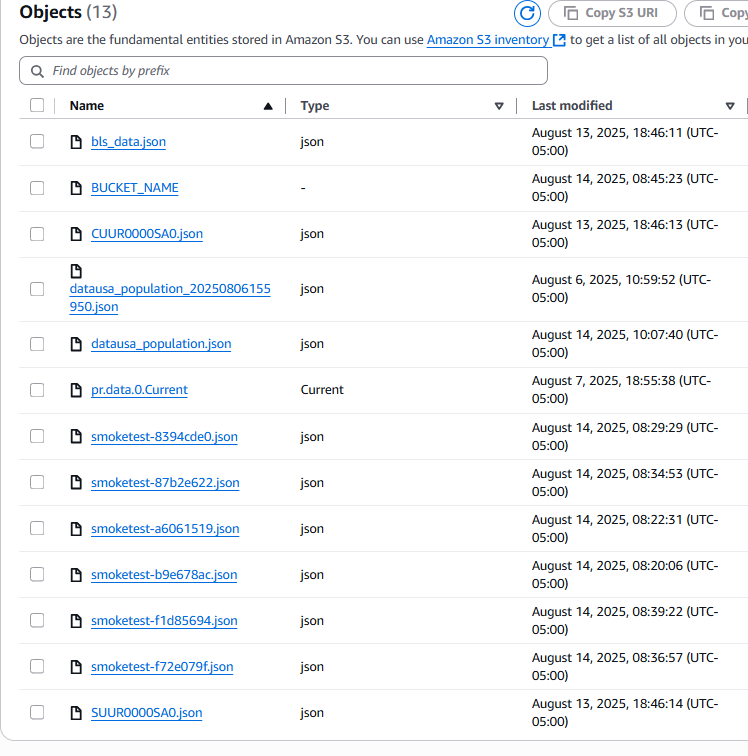

*AWS S3 bucket with ingested datasets and pipeline verification files.*

In [1]:
import os, json, boto3
import requests
import hashlib
from kaggle_secrets import UserSecretsClient
import time 
start = time.time()
print("Running..")

# Load AWS secrets
secrets = UserSecretsClient()
API_KEY = secrets.get_secret("BLS_API_KEY")
AWS_ACCESS_KEY_ID = secrets.get_secret("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = secrets.get_secret("AWS_SECRET_ACCESS_KEY")
AWS_REGION = secrets.get_secret("AWS_REGION")
BUCKET_NAME = secrets.get_secret("BUCKET_NAME")

# Setup AWS session and S3
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)
s3 = session.client("s3")

# Test S3 connection WITHOUT revealing keys
try:
    response = s3.list_objects_v2(Bucket=BUCKET_NAME)
    num_files = response.get('KeyCount', 0)
    print("S3 connection successful. Bucket contains: ", num_files)
except Exception as e:
    print("S3 connection failed: ", e)
print("Done.")

Running..
S3 connection successful. Bucket contains:  13
Done.


In [2]:
secrets = UserSecretsClient()

# Pull from Kaggle Secrets and mirror into environment vars
for key in ["AWS_ACCESS_KEY_ID", "AWS_SECRET_ACCESS_KEY", "AWS_REGION", "BUCKET_NAME"]:
    v = secrets.get_secret(key)
    if v:
        os.environ[key] = v

# If only AWS_REGION is set, mirror it to AWS_DEFAULT_REGION for libraries that expect that
if os.environ.get("AWS_REGION") and not os.environ.get("AWS_DEFAULT_REGION"):
    os.environ["AWS_DEFAULT_REGION"] = os.environ["AWS_REGION"]

print("Exported Kaggle secrets to env vars.")

Exported Kaggle secrets to env vars.


In [3]:
REGION = os.environ.get("AWS_DEFAULT_REGION", "us-east-1")
sqs = boto3.client("sqs", region_name=REGION)

resp = sqs.create_queue(
    QueueName="JsonWriteQueue",
    Attributes={"VisibilityTimeout": "300"}  # seconds
)
QUEUE_URL = resp["QueueUrl"]
QUEUE_ATTR = sqs.get_queue_attributes(QueueUrl=QUEUE_URL, AttributeNames=["QueueArn"])
QUEUE_ARN = QUEUE_ATTR["Attributes"]["QueueArn"]

print("SQS ready")
print("ARN ready")

SQS ready
ARN ready


In [4]:
#LAMBDA SMOKE TEST: 
lam = session.client("lambda")
fns = lam.list_functions()['Functions']
names = []
for function in fns:
    name = function["FunctionName"]
    names.append(name)
print("Functions:", names)

Functions: ['BlsPipelineStack-BlsReportFn1ABE5E21-0qZIzspWVVtL', 'CFN-SM-IM-Lambda-catalog-DelayLambda-GH20qvggV0UO', 'BlsPipelineStack-BlsIngestFnCD0BBA37-KqHbWeaT1WT3', 'bls-ingest', 'CFGetCatalogRoles', 'RearcBLSLambda', 'CFGetDefaultVpcIdTut', 'MyFirstLambda', 'S3FileProcessorLambda', 'GitHubWebhookLambda', 'BlsPipelineStack-BucketNotificationsHandler050a058-iFZUwiLm9Toh', 'CFEnableSagemakerProjectsTut']


In [5]:
import os, boto3
from botocore.exceptions import ClientError

REGION = os.getenv("AWS_DEFAULT_REGION", "us-east-1")
QUEUE_NAME = "BlsPipelineStack-JsonWriteQueue5A3EABE8-LZV3FOGqIIfU"  # your CDK queue

sqs = boto3.client("sqs", region_name=REGION)

try:
    QUEUE_URL = sqs.get_queue_url(QueueName=QUEUE_NAME)["QueueUrl"]
    QUEUE_ARN = sqs.get_queue_attributes(
        QueueUrl=QUEUE_URL,
        AttributeNames=["QueueArn"]
    )["Attributes"]["QueueArn"]
    print("SQS ready")
except ClientError as e:
    print("Failed to resolve existing queue:", e)

SQS ready


In [6]:
from botocore.config import Config

# CONFIG:
AWS_REGION = os.getenv("AWS_REGION", "us-east-1")
INGEST_LAMBDA = os.getenv("INGEST_LAMBDA", "RearcBLSLambda")  # your new ingest function

# boto3 client with sensible timeouts/retries
lam = boto3.client(
    "lambda",
    region_name=AWS_REGION,
    config=Config(connect_timeout=3, read_timeout=10, retries={"max_attempts": 2})
)

# INVOKE:
resp = lam.invoke(
    FunctionName=INGEST_LAMBDA,
    InvocationType="RequestResponse",
    Payload=json.dumps({}).encode("utf-8")  # send an empty JSON payload
)

status = resp.get("StatusCode")
print("Status:", status)

Status: 200


In [7]:
# Show function errors if any
err = resp.get("FunctionError")
if err:
    print("FunctionError:", resp["FunctionError"])

# Response payload
raw = resp["Payload"].read()
if raw:
    try:
        payload = json.loads(raw)
        # Try parsing "body" as JSON text.
        if isinstance(payload.get("body"), str):
            try:
                payload["body"] = json.loads(payload["body"])
            except Exception:
                pass
        print("Payload:", json.dumps(payload, indent=2)[:2000])
    except Exception:
        print("Payload (raw):", raw[:2000])

# Status Code:
if status == 200 and not err:
    print("Success: ", status)
else:
    print("Issue", status, err or "")

Payload: {
  "statusCode": 200,
  "body": "upload complete"
}
Success:  200


In [8]:
import json, base64
resp = lam.invoke(
    FunctionName=INGEST_LAMBDA,  # your Lambda name
    InvocationType="RequestResponse"
)
status = resp.get("StatusCode")
err = resp.get("FunctionError")

# Read the payload ONCE
raw_payload = resp["Payload"].read()

# Decode Lambda logs if they exist
if "LogResult" in resp:
    print("Lambda Logs")
    print(base64.b64decode(resp["LogResult"]).decode("utf-8", "ignore"))

# Decode 
if raw_payload:
    try:
        payload_json = json.loads(raw_payload.decode("utf-8"))
        print("Payload")
        print(json.dumps(payload_json, indent=2))
    except Exception:
        print("Payload (raw)")
        print(raw_payload.decode("utf-8", "ignore"))
else:
    print("Payload is empty")

if status == 200:
    print("Result. Status = 200")
else:
    print("Error: ", err)

Payload
{
  "statusCode": 200,
  "body": "upload complete"
}
Result. Status = 200


In [9]:
# Verify Right Region:
s3 = boto3.client("s3", region_name=os.getenv("AWS_REGION") or "us-east-1")
loc = s3.get_bucket_location(Bucket=BUCKET_NAME).get("LocationConstraint") or "us-east-1"
print("BucketRegion==ClientRegion?", loc == s3.meta.region_name)

BucketRegion==ClientRegion? True


In [10]:
from botocore.exceptions import ClientError
# File Names:
print([o["Key"] for o in s3.list_objects_v2(Bucket=BUCKET_NAME).get("Contents", [])[:10]])

['BUCKET_NAME', 'CUUR0000SA0.json', 'SUUR0000SA0.json', 'bls_data.json', 'datausa_population.json', 'datausa_population_20250806155950.json', 'pr.data.0.Current', 'smoketest-8394cde0.json', 'smoketest-87b2e622.json', 'smoketest-a6061519.json']


In [11]:
resp = s3.list_objects_v2(Bucket=BUCKET_NAME)

# This summary is all info we need and has no secret info:
summary = {
    "status": resp["ResponseMetadata"]["HTTPStatusCode"],
    "key_count": resp.get("KeyCount", 0),
    "truncated": bool(resp.get("IsTruncated")),
}
print(summary)

{'status': 200, 'key_count': 13, 'truncated': False}


In [12]:
resp = s3.list_objects_v2(Bucket=BUCKET_NAME)
for o in resp.get("Contents", []):
    print(o["Key"])  # or process
print("Done")

BUCKET_NAME
CUUR0000SA0.json
SUUR0000SA0.json
bls_data.json
datausa_population.json
datausa_population_20250806155950.json
pr.data.0.Current
smoketest-8394cde0.json
smoketest-87b2e622.json
smoketest-a6061519.json
smoketest-b9e678ac.json
smoketest-f1d85694.json
smoketest-f72e079f.json
Done


In [13]:
import uuid

# Checks if S3 event happened and queue emptied..
PREFIX = ""  # for root
test_key = f"{PREFIX}smoketest-{uuid.uuid4().hex[:8]}.json"

# 1) Upload test file to trigger pipeline (should trigger S3->SQS->Lambda)
s3.put_object(Bucket=BUCKET_NAME, Key=test_key, Body=b'{"ping":true}')

# Queue depth 0 → Report Lambda processed message
qurl = QUEUE_URL  # assigns the QUEUE_URL
def depth():
    a = sqs.get_queue_attributes(
        QueueUrl=qurl,
        AttributeNames=["ApproximateNumberOfMessages"]
    )["Attributes"]["ApproximateNumberOfMessages"]
    return int(a)

# Check Queue Until Empty:
for _ in range(12):  
    time.sleep(1)
    if depth() == 0:
        break

# cleanup the test object
s3.delete_object(Bucket=BUCKET_NAME, Key=test_key)
print("E2E smoke: PASS")

E2E smoke: PASS


In [14]:
end = time.time()
print(round(end - start, 2), " seconds")

5.8  seconds


### Conclusion
That wraps up Part 4 Python version – Infrastructure as Code & the automated pipeline.

**[View GitHub Repository with All Parts](https://github.com/ScottySchmidt/AWS_DataEngineer_API)**